# Optimizing the H2 Cavity

Having simulated and analyzed the modes 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PhC cavity simulation

We will look at a cavity simulation similar to the previous Notebook and see how it can be improved both in terms of accuracy and in terms of computational time and memory. We first define the cavity that we will simulate. This time we use a silicon slab in air because of the larger photonic band gap. This will come in handy later.

In [10]:
# Number of PhC periods in x and y directions
Nx, Ny = 18, 18
a=1
# Regular PhC parameters
dslab = 0.26/0.366*a
n_slab = 3.4
ra = 0.344*a


# Initialize a lattice and PhC
lattice = legume.Lattice([Nx*a, 0], [0, Ny*np.sqrt(3)/2*a])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx//2+1, Ny//2+1
for iy in range(ny):
    for ix in range(nx):
        if iy == 0 and ix in(0,1):
            continue
        if iy == 1 and ix ==0:
            continue
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

# Move the first two holes to create the L4/3 defect
nc = len(xp)

# Initialize shift parameters to zeros
dx, dy = np.zeros((nc,)), np.zeros((nc,))

array([[11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       ...,
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56]])

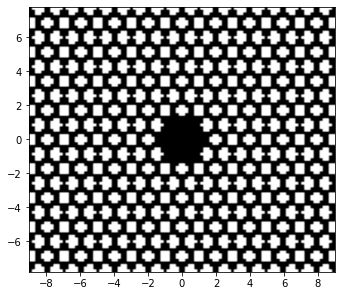

In [11]:
# Define L4/3 PhC cavity with shifted holes
def cavity(dx, dy):
    # Initialize PhC
    phc = legume.PhotCryst(lattice)

    # Add a layer to the PhC
    phc.add_layer(d=dslab, eps_b=n_slab**2)

    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic] if yp[ic] == 0 else yp[ic] + dy[ic]
        xc = x if x == 0 else xp[ic] + dx[ic]
        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
        if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=ra))
        if nx-1.6 > xp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=ra))
        if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
            phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=ra))
    return phc

phc=cavity(dx,dy)
legume.viz.eps_xy(phc, z=dslab/2, Nx=100, Ny=100)


In the previous example, we used a relatively fast optimization for illustration purposes. In the `legume` paper,
we use `gmax = 2.5`, as well as a 3x3 $k$-grid in the Brillouin zone, and average the loss rates.
This improves the accuracy of the result, especially when going to ultra-high-$Q$ values.
However, it also takes a longer time to compute, and significantly more memory if done directly, because all the variables,
including all the dense matrices and all the eigenvectors at every $k$ are stored for the backpropagation.
We will see how we can introduce some improvements.

Below, we define a new GME computation function, with two main differences from the previous Notebook. First, we compute the loss rates on a grid of $k$-points. Second, instead of taking the `Nx*Ny` eigenmode as the cavity mode, we look for the first eigenfrequency above 0.26 (first mode in the band gap), since below we will try a solver for that only computes a small number of eigenmodes. The large band-gap of the silicon PhC helps with defining a cutoff frequency when looking for the cavity mode, especially as parameters change during an optimization.

In [12]:
def gme_cavity_k(dx, dy, gmax, options, kpoints, f_lb=0.2645):
    phc = cavity(dx, dy)

    options['compute_im'] = False

    gme = legume.GuidedModeExp(phc, gmax=gmax)
    gme.run(kpoints=kpoints, **options)
    indmode = npa.nonzero(gme.freqs[0, :] > f_lb)[0][0]
    fims = []

    for ik in range(kpoints[0, :].size):
        (freq_im, _, _) = gme.compute_rad(ik, [indmode])
        fims.append(freq_im)
    target_frequency =npa.mean(gme.freqs[0])

    if not hasattr(target_frequency, "_value"):
        options['eig_sigma'] = target_frequency

    return (gme, npa.array(fims), indmode)

## Accuracy of forward computation
We first compare the quality factor computed at a single $k$-point to the one computed after averaging over a small grid in $k$-space. To speed things up here, we'll only use `gmax = 1.5` and a 2x2 grid in $k$. Note that it's better to average the loss rates and only then compute the $Q$, rather than average the $Q$-s.

Instead of computing `Nx*Ny` modes like before, here we will only compute 5 modes closes to $f=0.28$, which is where we expect the cavity mode to lie (we've checked in a previous simulation). When using the default solver, `numpy.linalg.eigh`, this actually doesn't make any difference, because *all* the eigenmodes are computed, but only the requested ones are stored. However, below we will also test using the `scipy.sparse.linagl.eigsh` solver, which only computes the requested number `numeig` of eigenmodes.

We measure the memory using the magic function from the [memory profiler](https://pypi.org/project/memory-profiler/), which you should have installed to run the cells below (or comment out the `%memit` commands).

In [13]:
# Load the memory profiler
%load_ext memory_profiler

# Set some GME options
options = {'gmode_inds': [0], 'verbose': True, 'gradients': 'exact',
           'numeig': 1,       # get 5 eigenvalues
           'eig_sigma': 0.341  # closest to f = 0.28
          }
gmax = 2

# Create a grid in k space (non-negative kx, ky only)
nkx = 2
nky = 2
kx = np.linspace(0, np.pi/Nx, nkx)
ky = np.linspace(0, np.pi/Ny/np.sqrt(3)*2, nky)
kxg, kyg = np.meshgrid(kx, ky)
kxg = kxg.ravel()
kyg = kyg.ravel()

options['eig_solver'] = 'eigsh'

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Time and memory performance of gradient computation

Now we will compare several different ways to compute the gradient of the $k$-averaged loss rates. Note that the memory measurement is not exact and could vary between runs, but it gives us a good idea of what's happening.

In [14]:
# Switch to autograd backend
legume.set_backend('autograd')

# Starting parameters
pstart = np.zeros((2*nc, ))

# Objective function defining the average imaginary part
def fim_kavg(params):
    dx = params[0:nc]
    dy = params[nc:]
    (gme, fims, _) = gme_cavity_k(dx, dy, gmax, options, np.vstack((kxg, kyg)))
    # Scale for easier readability
    return npa.mean(fims)*1e6

obj_grad = value_and_grad(fim_kavg)

This is faster and takes a little less memory, but it doesn't help reduce the memory requirement as much as we would like. This is because, the only difference is that we don't store all the eigenvectors. However, all the intermediate results in building the matrix for diagonalization, including the matrix itself, are still stored and form the bulk of the memory requirement. To make matters worse, they are stored for every $k$-point, as opposed to discarded at the end of each loop as is the case of the forward computation.

To mitigate this, we also provide a custom function that mimics `map(lambda f: f(params), fns))` in a way that splits the gradient computation instead of storing all the intermediate variables for all functions. NB: the function `fns` all have to return a scalar and `params` are all vectors. `fmap` then returns an array of the same size as the number of functions in `fns`.

In [15]:
from legume.primitives import fmap

# Redefine the objective function to utilize the `legume.fmap` function
def of_kavg_fmap(params):
    # A function factory to make a list of functions for every k-point
    def fim_factory(ik):
        def fim(params):
            dx = params[0:nc]
            dy = params[nc:]
            (gme, freq_im, _) = gme_cavity_k(dx, dy, gmax, options, np.array([[kxg[ik]], [kyg[ik]]]))
            return freq_im
        return fim

    fims = fmap([fim_factory(ik=ik) for ik in range(nkx*nky)], params)
    return npa.mean(fims)*1e6

In [16]:
opt = Minimize(of_kavg_fmap)

# Starting parameters are the un-modified cavity
pstart = np.zeros((2*nc, ))

options["verbose"]=False
# Run an 'adam' optimization
(p_opt, ofs) = opt.adam(pstart, step_size=0.005, Nepochs=20, bounds = [-0.25, 0.25], pass_self=False)

17.4460s total time for real part of frequencies, of which
  0.4250s for guided modes computation using the gmode_compute='exact' method
  2.0565s for inverse matrix of Fourier-space permittivity
  2.2730s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
17.0327s total time for real part of frequencies, of which
  0.4380s for guided modes computation using the gmode_compute='exact' method
  1.9690s for inverse matrix of Fourier-space permittivity
  1.7665s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
16.9614s total time for real part of frequencies, of which
  0.3910s for guided modes computation using the gmode_compute='exact' method
  2.0188s for inverse matrix of Fourier-space permittivity
  1.7550s for matrix d

Note that the Q increased by almost two orders of magnitude in just 10 steps of the Adam optimization! Let's visuzlize the optimized cavity below.

In [19]:
# Optimized parameters
dx = p_opt[0:nc]
dy = p_opt[nc:]

# Run the simulation

(gme, freq_im, _) = gme_cavity_k(dx, dy, gmax, options, np.array([[kxg[0]], [kyg[0]]]))

19.5020s total time for real part of frequencies, of which
  0.4210s for guided modes computation using the gmode_compute='exact' method
  4.7210s for inverse matrix of Fourier-space permittivity
  1.7000s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


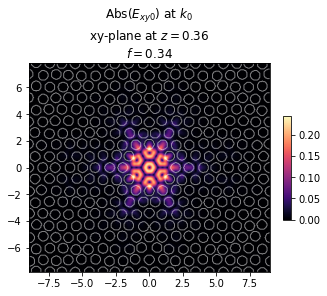

In [20]:
ax = legume.viz.field(gme, 'e', 0, 0, z=dslab/2, component='xy', val='abs', N1=300, N2=300,norm=True)

In [21]:
freq_im, _, _=gme.compute_rad(0,[0])

In [22]:
print(freq_im)
print(gme.freqs[0][0]/2/freq_im)

[1.55580581e-06]
[109558.10758617]


In [23]:
options['numeig'] = 1
(gme, freq_im, _) = gme_cavity_k(pstart[0:nc], pstart[nc:], gmax, options, np.array([[kxg[0]], [kyg[0]]]))
print(freq_im)
print(gme.freqs[0][0]/2/freq_im)

17.3600s total time for real part of frequencies, of which
  0.4190s for guided modes computation using the gmode_compute='exact' method
  2.1010s for inverse matrix of Fourier-space permittivity
  1.8320s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
[[3.76143127e-05]]
[[4546.64173179]]


In [24]:
phc_start=cavity(pstart[0:nc], pstart[nc:])
phc_opt=cavity(dx, dy)

In [25]:
(xgrid, ygrid) = phc.lattice.xy_grid(Nx=300, Ny=300)
[xmesh, ymesh] = np.meshgrid(xgrid, ygrid)
zmesh = dslab/2*np.ones(xmesh.shape)

extent = [xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]]

eps_start = phc_start.get_eps((xmesh, ymesh, zmesh))
eps_opt = phc_opt.get_eps((xmesh, ymesh, zmesh))

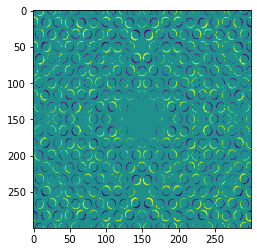

In [26]:
plt.imshow(eps_start-eps_opt)